In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from geometry import *

In [5]:
def rotate(th):
    return np.array([[np.cos(th), np.sin(th)],[-np.sin(th), np.cos(th)]])

In [6]:
from geometry import *
from visualize import *

In [18]:
d = .142 # nm
m, r = 5, 1
geom = Geom(d, m, r)

In [19]:
pts = get_tbg_unit_cell(geom)

In [20]:
sum([len(pts[k]) for k in pts]), geom.N

(364, 364)

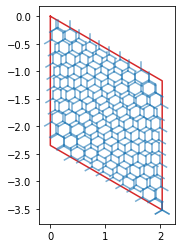

In [14]:
plot_unit_cell(geom.aM)
plot_lattice(pts['A1'], geom.deltas)
plot_lattice(pts['A2'], geom.deltas)

# Initial experiments below this line
This is all in `geometry.py` and `visualize.py` now

In [6]:
d = .142 # nm
m, r = 31, 1

num_atoms = 4*(3*m*m +3*m*r+r*r)
theta = np.arccos((3*m*m + 3*m*r + r*r/2) / (3*m*m + 3*m*r + r*r))
L = d * np.sqrt(3) / (2 * np.sin(theta/2.))
nn = d * np.array([0, 1])
deltas = np.array([nn, rotate(2*np.pi/3) @ nn, rotate(-2*np.pi/3) @ nn])
tau0 = d * np.sqrt(3) * np.array([[np.sqrt(3)/2., 0.5],[1., 0.]])

In [584]:
a = np.sqrt(3) * d * np.array([[1., 0.],[0.5, np.sqrt(3)/2.],])
b = 2*np.pi*np.linalg.inv(a) # columns are vectors
R = rotate(theta / 2.)
bM = R @ b - R.T @ b
aM = 2*np.pi*np.linalg.inv(bM) # rows are vectors
unit_cell = np.array([[0., 0.], aM[0], aM[0]+aM[1], aM[1]])


In [11]:
Geom(d,m,r)

Geom(d=0.142, m=31, r=1, theta=0.01832806689635094, N=11908, L=13.419563480233716, deltas=array([[ 0.        ,  0.142     ],
       [ 0.12297561, -0.071     ],
       [-0.12297561, -0.071     ]]), a=array([[0.24595121, 0.        ],
       [0.12297561, 0.213     ]]), b=array([[ 25.54646992,   0.        ],
       [-14.74926128,  29.49852257]]), bM=array([[-0.27032166,  0.54064333],
       [-0.46821086,  0.        ]]), aM=array([[ -0.        , -13.41956348],
       [ 11.62168288,  -6.70978174]]), unit_cell=array([[  0.        ,   0.        ],
       [ -0.        , -13.41956348],
       [ 11.62168288, -20.12934522],
       [ 11.62168288,  -6.70978174]]))

In [585]:
def plot_box(a, d=None, c='C3'):
    pts = np.array([[0., 0.], a[0], a[0]+a[1], a[1], [0.,0.]])
    if d is not None:
        pts += d
    plt.plot(pts.T[0], pts.T[1], c=c)

In [586]:
def plot_lattice(pts, nearest_neighbors, c='C0', alpha=.6):
    for pt in pts:
        for nn in nearest_neighbors:
            end = pt + nn
            plt.plot([pt[0], end[0]], [pt[1], end[1]], c=c, alpha=alpha)

In [587]:
def get_points_in_unit_cell(pts, a):
    """ Returns all points within the unit cell defined by the vectors
    a[0] and a[1]
    """
    eps = -(a[0] + a[1]) # necessary to avoid double counting at the boundary
    eps = (1.e-9) * (eps / np.linalg.norm(eps))
    decomp = np.tensordot(np.linalg.inv(a.T), pts + eps, [1,1]).T
    mask = (decomp[:, 0] > 0) & (decomp[:, 0] < 1) & (decomp[:, 1] > 0) & (decomp[:, 1] < 1)
    return pts[mask], mask

In [588]:
mn_top = np.array(np.linalg.inv((rotate(theta/2.) @ a.T)) @ unit_cell.T, dtype=int) # rotated 
mn_bot = np.array(np.linalg.inv((rotate(-theta/2.) @ a.T)) @ unit_cell.T, dtype=int)

In [592]:
#plt.figure(figsize=(20,20))
#plt.gca().set_aspect(1.)
j = 0

pts = []

for mn in [mn_top, mn_bot]:
    
    mn = np.array(np.meshgrid(np.arange(np.min(mn[0])-1,np.max(mn[0])+1),
                              np.arange(np.min(mn[1])-1,np.max(mn[1])+1)
                             )
                ).reshape(2,-1)

    sl_pts = np.tensordot(a, mn, [0, 0]).T
    sl_pts_rot = (rotate((-1)**j * theta/2.) @ sl_pts.T).T
    deltas_rot = (rotate((-1)**j * theta/2.) @ deltas.T).T

    #plot_lattice(sl_pts_rot, deltas_rot, alpha=1-.3*j, c=f"C{2*j}")
    unit_cell_A, _ = get_points_in_unit_cell(sl_pts_rot, aM)
    
    # Don't use unit_cell_B to seed -- it's fewer points but you need
    # to deal with double counting
    sl_pts_B = sl_pts_rot + deltas_rot[0] 
    unit_cell_B, _ = get_points_in_unit_cell(sl_pts_B, aM)
    
    pts.extend(list(unit_cell_A))
    pts.extend(list(unit_cell_B))

    j += 1

pts = np.array(pts)
#plt.scatter(pts.T[0], pts.T[1], c='C1')
#plot_box(aM)

In [14]:
rotate(0.431) @ rotate(0.431).T

array([[1., 0.],
       [0., 1.]])

In [594]:
num_atoms

11908

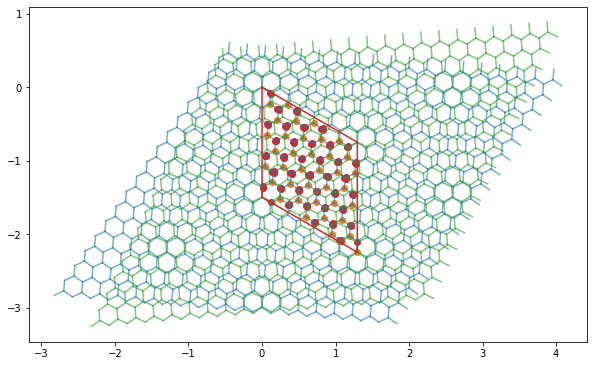

In [453]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect(1.)
plot_lattice(sl_pts_top, deltas_top)
plot_lattice(sl_pts_bot, deltas_bot, c='C2')

top_unit_cell_A, _ = get_points_in_unit_cell(sl_pts_top, aM)
sl_pts_top_B = np.vstack([sl_pts_top + d for d in deltas])
top_unit_cell_B, _ = get_points_in_unit_cell(sl_pts_top_B, aM)

# top_unit_cell_B 

plt.scatter(top_unit_cell_A.T[0], top_unit_cell_A.T[1], c='C1')
plt.scatter(top_unit_cell_B.T[0], top_unit_cell_B.T[1], c='C3')

plot_box(aM)#, d=-aM[1])

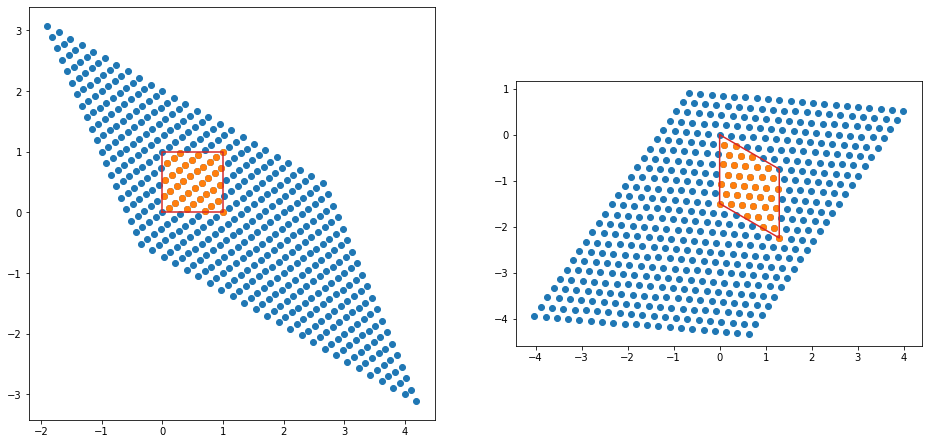

In [355]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.gca().set_aspect(1.)

plot_box(np.linalg.inv(aM) @ aM)
plt.scatter(transf_sl_pts.T[0], transf_sl_pts.T[1])
inside_pts = transf_sl_pts[mask]
plt.scatter(inside_pts.T[0], inside_pts.T[1])
#plt.scatter(*transf_sl_pts[137])

plt.subplot(1,2,2)
plt.gca().set_aspect(1.)
plot_box(aM)
plt.scatter(sl_pts_top.T[0], sl_pts_top.T[1])

transf_inside_pts = np.array([aM.T @ pt for pt in inside_pts]).T
plt.scatter(transf_inside_pts[0], transf_inside_pts[1])

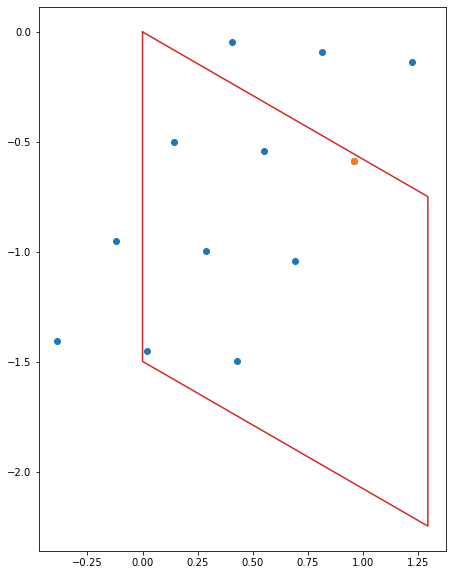

In [279]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect(1.)
#plot_lattice(sl_pts_top, deltas_top)
#plot_lattic2 e(sl_pts_bot, deltas_bot, c='C1')
plot_box(aM @ np.linalg.inv(aM) @ aM)
inside_pts = np.array([aM @ pt for pt in transf_sl_pts[mask]])
plt.scatter(inside_pts.T[0], inside_pts.T[1])
#inside_pts =  np.tensordot(aM, transf_sl_pts[mask], [1,1]).T
#plt.scatter(inside_pts[:, 0], inside_pts[:, 1], c='C1')
plt.scatter(*inside_pts[10])